# Temperature VS lexical diversity and coherence

## Setup

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from text_analysis import clean_text, get_language_confidence, get_vocabulary_coverage, calculate_mtld

In [2]:
# Load model
sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Load data
with open('results/results_openai.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
print(f"Loaded {len(df)} samples")
print(f"Temperature range: {df['temperature'].min():.1f} - {df['temperature'].max():.1f}")
df.head()

Loaded 630 samples
Temperature range: 0.0 - 2.0


,prompt_label,user_prompt,temperature,iteration,text
0,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,1,"Elio : Tu crois qu’on devrait tout lui dire, m..."
1,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,2,Elio : Tu crois qu’on peut vraiment tout recom...
2,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,3,"Elio : Tu crois qu’on devrait tout lui dire, m..."
3,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,4,Elio : Tu crois qu’on peut vraiment tout recom...
4,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,5,"Elio : Tu crois qu’on devrait tout lui dire, m..."


## Load analysis tools

In [3]:
def simple_analysis(row):
    text = row if isinstance(row, str) else row.get('text', '')
    
    # STEP 1: CLEAN TEXT
    text = clean_text(text)
    
    # STEP 2: METRIC Language confidence
    detected_lang, lang_confidence = get_language_confidence(text)
    
    # STEP 3: METRIC Vocabulary coverage  
    vocab_coverage = get_vocabulary_coverage(text)
    
    # STEP 4: METRIC MTLD
    mtld_score = calculate_mtld(text)
    
    # STEP 5: METRIC Semantic similarity
    semantic_similarity = 0.0
    if not isinstance(row, str):
        prompt = row.get('user_prompt', '')
        if prompt.strip() and text.strip():
            try:
                # Use the already-loaded global model
                embeddings = sbert_model.encode([prompt, text])
                semantic_similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
                semantic_similarity = max(0.0, float(semantic_similarity))
            except Exception as e:
                print(f"Error: {e}")
                semantic_similarity = 0.0
    
    return {
        'language_confidence': lang_confidence,
        'vocab_coverage': vocab_coverage, 
        'mtld': mtld_score,
        'semantic_similarity': semantic_similarity
    }

In [ ]:
results = []
for i, row in df.iterrows():
    metrics = simple_analysis(row)  # Pass entire row, not row['text']
    if metrics:
        ordered_metrics = {
            'temperature': row['temperature'],
            'iteration': row['iteration'],
            'language_confidence': metrics['language_confidence'],
            'vocab_coverage': metrics['vocab_coverage'],
            'mtld': metrics['mtld'],
            'semantic_similarity': metrics['semantic_similarity']
        }
        results.append(ordered_metrics)

analysis_df = pd.DataFrame(results)

# Sort by temperature (low to high)
analysis_df = analysis_df.sort_values('temperature').reset_index(drop=True)

print(f"Analyzed {len(analysis_df)} samples")
print(f"Temperature distribution in sample: {sorted(analysis_df['temperature'].unique())}")
analysis_df.head(10)

Analyzed 630 samples
Temperature distribution in sample: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


,temperature,iteration,language_confidence,vocab_coverage,mtld,semantic_similarity
0,0.0,1,0.987874,1.000000,129.960000,0.707951
1,0.0,10,0.994441,1.000000,176.505000,0.528125
2,0.0,9,0.992323,1.000000,215.264000,0.474778
3,0.0,8,0.991537,1.000000,179.210769,0.504186
4,0.0,7,0.993113,1.000000,219.343158,0.477754
5,0.0,6,0.993588,1.000000,215.053333,0.512447
6,0.0,5,0.989170,1.000000,175.259259,0.434028
7,0.0,4,0.995942,1.000000,127.905806,0.603449
8,0.0,2,0.994593,1.000000,186.340000,0.508847
9,0.0,1,0.992330,1.000000,159.454815,0.547247


## Visualise analysis

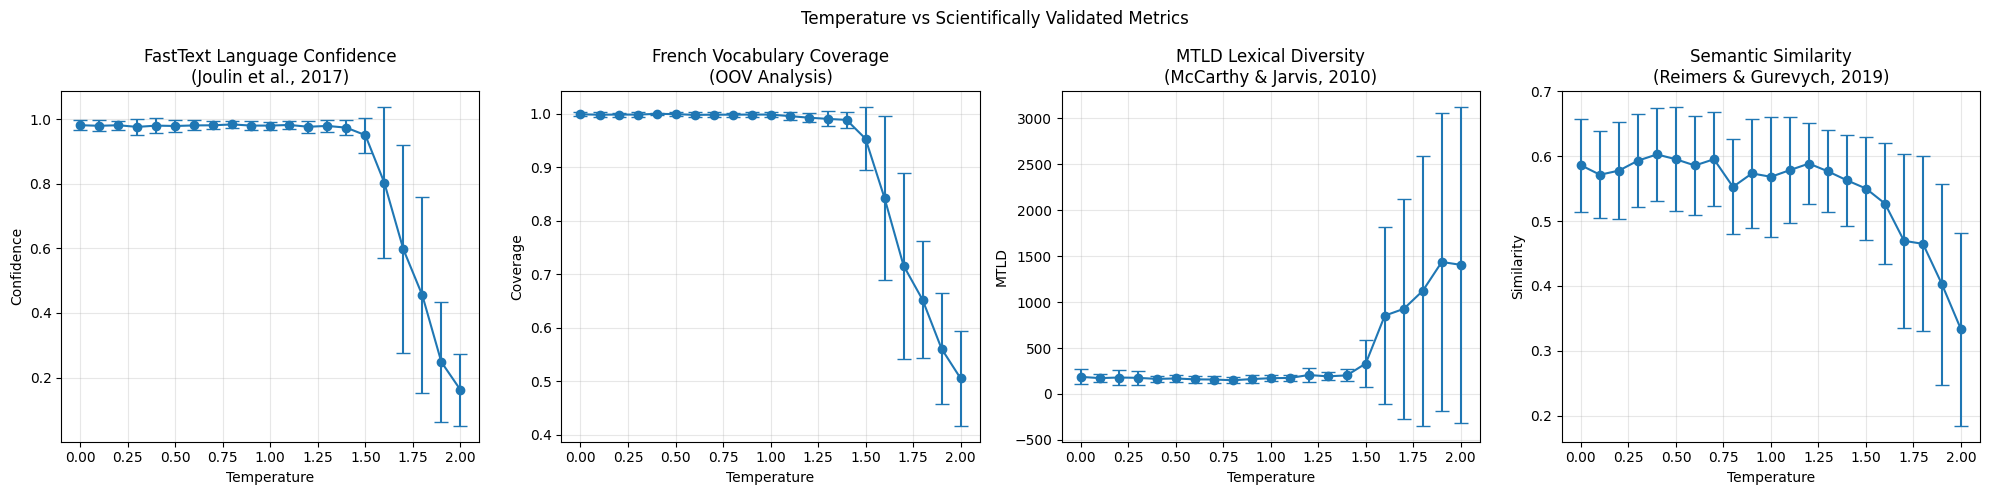

In [5]:
# Scientifically validated metrics only - NO ad-hoc composites
temp_stats = analysis_df.groupby('temperature').agg({
    'language_confidence': ['mean', 'std'],  # FastText (Joulin et al., 2017)
    'vocab_coverage': ['mean', 'std'],       # OOV analysis (standard NLP)
    'mtld': ['mean', 'std'],                 # MTLD (McCarthy & Jarvis, 2010)
    'semantic_similarity': ['mean', 'std']   # Sentence-BERT (Reimers & Gurevych, 2019)
}).reset_index()

# Flatten column names
temp_stats.columns = ['temperature', 'lang_conf_mean', 'lang_conf_std', 
                     'vocab_mean', 'vocab_std', 'mtld_mean', 'mtld_std',
                     'semantic_mean', 'semantic_std']

# Create plots with ONLY scientifically backed metrics
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Scientifically Validated Metrics')

# Language confidence (FastText - Joulin et al., 2017)
axes[0].errorbar(temp_stats['temperature'], temp_stats['lang_conf_mean'], 
                 yerr=temp_stats['lang_conf_std'], marker='o', capsize=5)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage (OOV analysis)
axes[1].errorbar(temp_stats['temperature'], temp_stats['vocab_mean'], 
                 yerr=temp_stats['vocab_std'], marker='o', capsize=5)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].grid(True, alpha=0.3)

# MTLD (McCarthy & Jarvis, 2010)
axes[2].errorbar(temp_stats['temperature'], temp_stats['mtld_mean'], 
                 yerr=temp_stats['mtld_std'], marker='o', capsize=5)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].grid(True, alpha=0.3)

# Semantic similarity (Reimers & Gurevych, 2019)
axes[3].errorbar(temp_stats['temperature'], temp_stats['semantic_mean'], 
                 yerr=temp_stats['semantic_std'], marker='o', capsize=5)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the aggregated data
# print("Temperature Statistics (Scientifically Validated Metrics Only):")
# print(temp_stats.round(3))

## Export